# **Bibliotecas**

In [137]:
# Pronóstico de Series de Tiempo

# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

# **Pronóstico de Series de Tiempo**

In [138]:
# Tomar datos del url en formato "raw"
url = 'https://raw.githubusercontent.com/eduardxmartinez/FisicaComputacional/master/Actividad1/2030.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha','Precip','Evap','Tmax','Tmin',]
df_tkt = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') 

# Hacemos una copia de trabajo y preservamos el dataframe original
df_tkt0 = df_tkt.copy()

# Cambiamos la palabra nulo por un vacío y verificamos
str_Nulo = 'Nulo'
df_tkt1 = df_tkt0.replace(to_replace=str_Nulo, value='', regex=True)

# Convertimos los valores de las variables ambientales a números flotantes y verificamos 
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_tkt1[cols] = pd.to_numeric(df_tkt0[cols], errors='coerce')

# Definimos un nuevo dataframe por si hay que regresarse
df_tkt2 = df_tkt1.copy()
df_tkt2['Fecha'].head()

# Se convierte el objeto Fecha a variable fecha que python reconoce
df_tkt2['Fecha'] = pd.to_datetime(df_tkt2['Fecha'], dayfirst=True).copy()

# Añadimos dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.month para extraer el Año y Mes de la Fecha
df_tkt2['Año'] = df_tkt2['Fecha'].dt.year
df_tkt2['Mes'] = df_tkt2['Fecha'].dt.month

# Hacemos una copia del trabajo y es con el que trabajaremos para el análisis de datos
df_meteotkt = df_tkt2.copy()

# Eliminamos la columna de Mes(numérico) y agregamos Mes(caractéres)
df_meteotkt.drop('Mes', axis=1, inplace=True)
df_meteotkt['Mes'] = df_meteotkt['Fecha'].dt.strftime('%b')
# print(df_meteotkt.head())
# print(df_meteotkt.tail())

# Nueva copia del DataFrame para Series de Tiempo
df_meteotkt_ts = df_meteotkt.copy()

# Reemplazamos el índice por la variable 'Fecha' 
df_meteotkt_ts = df_meteotkt.set_index('Fecha')
df_meteotkt_ts.info()

# Seleccionaremos un conjunto de años de 30 años
df_30 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1930) & (df_meteotkt_ts['Año'] < 1960)]
df_60 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1960) & (df_meteotkt_ts['Año'] < 1990)]
df_90 = df_meteotkt_ts[(df_meteotkt_ts['Año'] >= 1990) & (df_meteotkt_ts['Año'] < 2013)]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23084 entries, 1946-01-01 to 2012-10-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  23024 non-null  float64
 1   Evap    4447 non-null   float64
 2   Tmax    22382 non-null  float64
 3   Tmin    22384 non-null  float64
 4   Año     23084 non-null  int64  
 5   Mes     23084 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


In [139]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar', size=18)
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de  Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [140]:
# Creamos la primer serie de Tiempo para analizar, 
# haciendo una copia de la epoca de 1990 a 2017 
# o el periodo que se desee. Podemos regresar a esta punto las veces que se requiera definir

# Fechas de inicio y fin, para filtrar la información
start, end = '2003-03', '2008-2'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2003-03-01,0.0,NaN,15.0,4.0,2003,Mar
2003-03-02,0.0,NaN,19.0,3.0,2003,Mar
2003-03-03,20.0,NaN,12.0,2.0,2003,Mar
2003-03-04,5.4,NaN,12.0,2.0,2003,Mar
2003-03-05,0.0,NaN,17.0,3.0,2003,Mar


## **Temperatura Máxima**

In [141]:
# Vemos su encabezado
ts_90['Tmax'].head()

Fecha
2003-03-01    15.0
2003-03-02    19.0
2003-03-03    12.0
2003-03-04    12.0
2003-03-05    17.0
Name: Tmax, dtype: float64

In [142]:
# Definimos la Serie de Tiempo con Tmax que vamos a estudiar, le damos un nombre genérico
ts_test_TMX = ts_90['Tmax'].copy()

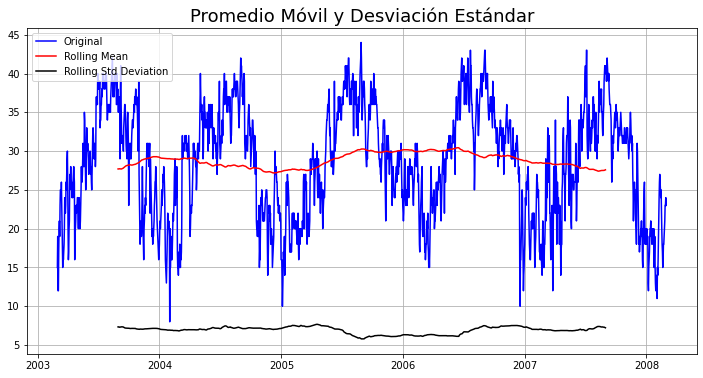

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.534290
p-value                           0.007149
#Lags Used                       16.000000
Number of Observations Used    1810.000000
Critical Value (1%)              -3.433968
Critical Value (5%)              -2.863138
Critical Value (10%)             -2.567621
dtype: float64


In [143]:
# Realizamos la Prueba de Estacionaridad de Tmax
test_stationarity(ts_test_TMX)

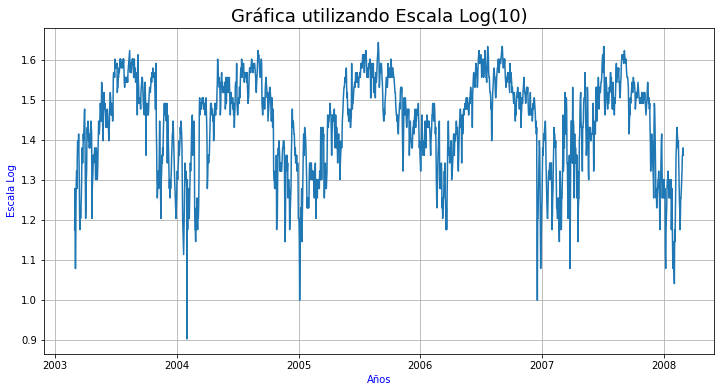

In [144]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMX_log = np.log10(ts_test_TMX)
plt.plot(ts_test_TMX_log)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

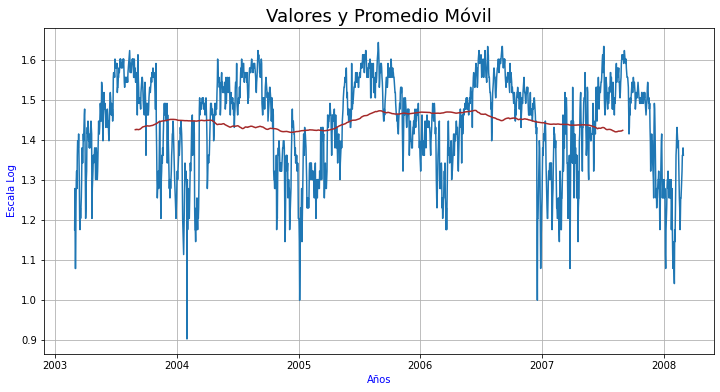

In [145]:
moving_avg_TMX = ts_test_TMX_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMX_log)
plt.plot(moving_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [146]:
ts_test_log_moving_ave_diff_TMX = ts_test_TMX_log - moving_avg_TMX 
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: Tmax, dtype: float64

In [147]:
ts_test_log_moving_ave_diff_TMX.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMX.head()

Fecha
2003-08-30    0.130486
2003-08-31    0.118103
2003-09-01    0.130618
2003-09-02    0.117901
2003-09-03    0.141693
Name: Tmax, dtype: float64

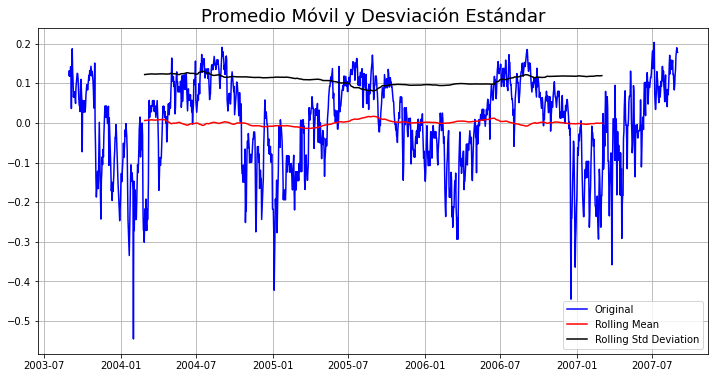

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.685522
p-value                           0.076577
#Lags Used                       23.000000
Number of Observations Used    1439.000000
Critical Value (1%)              -3.434902
Critical Value (5%)              -2.863551
Critical Value (10%)             -2.567840
dtype: float64


In [148]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMX)

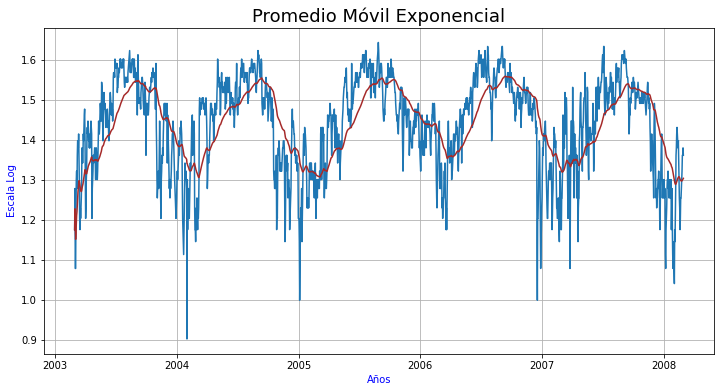

In [149]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMX = ts_test_TMX_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMX_log)
plt.plot(EWM_avg_TMX, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [150]:
EWM_avg_TMX.head()

Fecha
2003-03-01    1.176091
2003-03-02    1.228015
2003-03-03    1.177253
2003-03-04    1.151879
2003-03-05    1.168328
Name: Tmax, dtype: float64

In [151]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMX = ts_test_TMX_log - EWM_avg_TMX

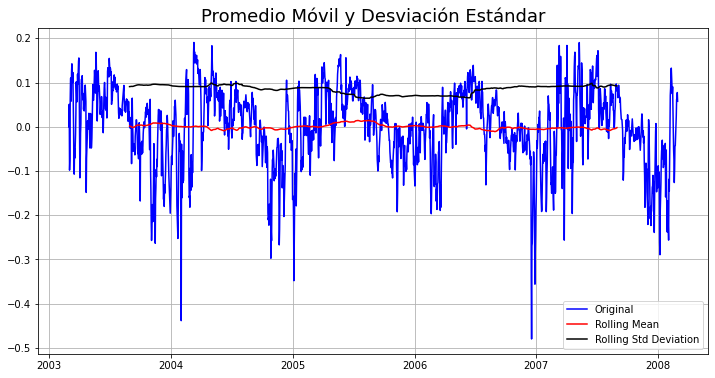

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.838884
p-value                           0.002534
#Lags Used                       25.000000
Number of Observations Used    1801.000000
Critical Value (1%)              -3.433986
Critical Value (5%)              -2.863146
Critical Value (10%)             -2.567625
dtype: float64


In [152]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMX)

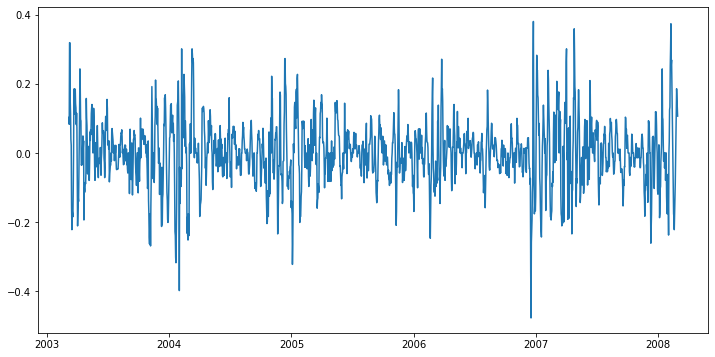

In [153]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMX = ts_test_TMX_log - ts_test_TMX_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMX);

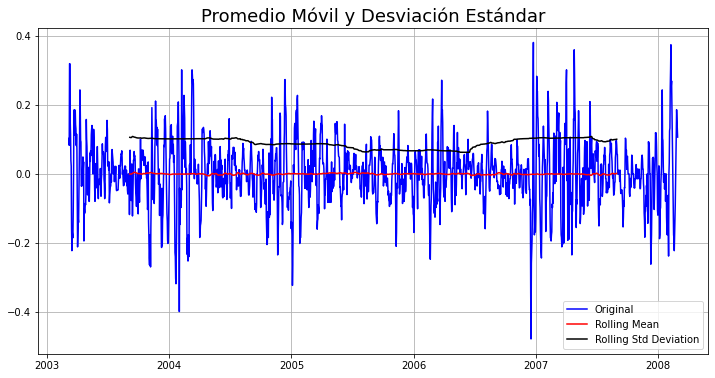

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.076043e+01
p-value                        2.529134e-19
#Lags Used                     2.400000e+01
Number of Observations Used    1.795000e+03
Critical Value (1%)           -3.433998e+00
Critical Value (5%)           -2.863152e+00
Critical Value (10%)          -2.567628e+00
dtype: float64


In [154]:
# Probamos la estacionaridad
ts_test_log_diff_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMX)

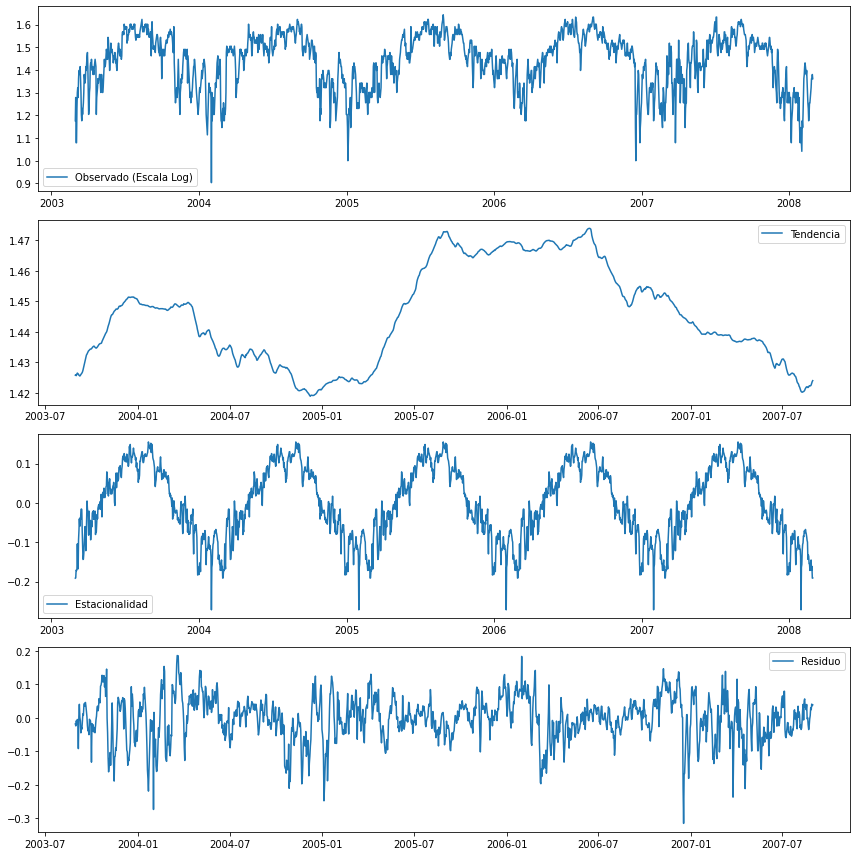

In [155]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMX = sm.tsa.seasonal_decompose(ts_test_TMX_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMX = decomposition_TMX.trend
seasonal_TMX = decomposition_TMX.seasonal
residue_TMX = decomposition_TMX.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMX_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMX, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMX, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMX, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

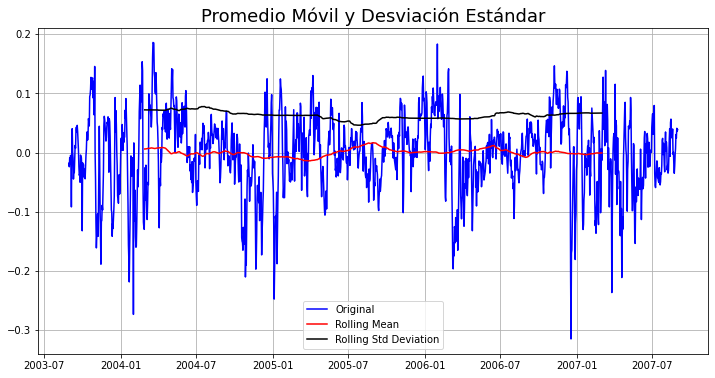

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -5.709754e+00
p-value                        7.346061e-07
#Lags Used                     2.300000e+01
Number of Observations Used    1.439000e+03
Critical Value (1%)           -3.434902e+00
Critical Value (5%)           -2.863551e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


In [156]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMX = residue_TMX 
ts_test_log_decompose_TMX.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMX)

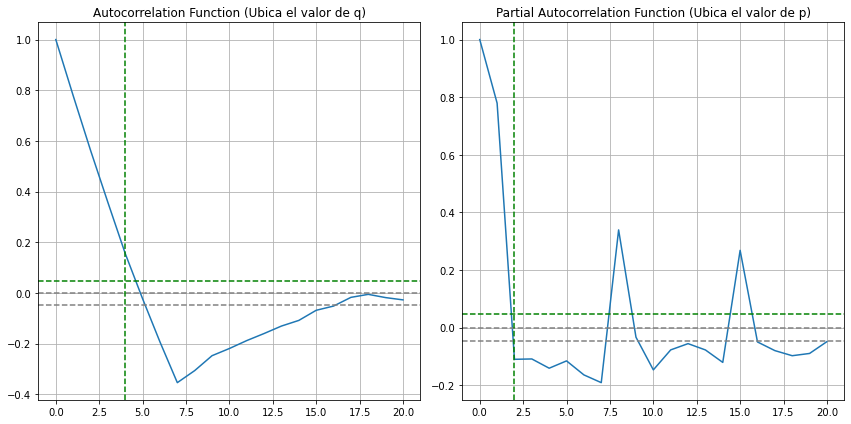

In [157]:
# Aplicamos ARIMA

lag_acf_TMX = acf(ts_test_log_diff_TMX, nlags=20)
lag_pacf_TMX = pacf(ts_test_log_diff_TMX, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMX)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMX)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1826
Model:                 ARIMA(2, 1, 0)   Log Likelihood                3153.805
Method:                       css-mle   S.D. of innovations              0.043
Date:                Sat, 20 Feb 2021   AIC                          -6299.611
Time:                        01:30:59   BIC                          -6277.571
Sample:                    03-02-2003   HQIC                         -6291.481
                         - 02-29-2008                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0001      0.001      0.112      0.911      -0.002       0.002
ar.L1.D.Tmax    -0.0643      0.023     -2.747      0.006      -0.110      -0.018
ar.L2.D.Tmax    -0.0462      0.024     -1.96

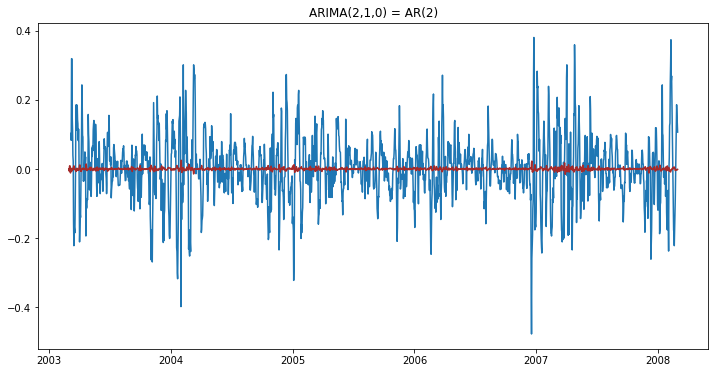

In [158]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,0), missing='drop')
results_AR_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_AR_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1826
Model:                 ARIMA(0, 1, 5)   Log Likelihood                3186.017
Method:                       css-mle   S.D. of innovations              0.042
Date:                Sat, 20 Feb 2021   AIC                          -6358.034
Time:                        01:31:00   BIC                          -6319.465
Sample:                    03-02-2003   HQIC                         -6343.807
                         - 02-29-2008                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.765e-05      0.000      0.137      0.891      -0.001       0.001
ma.L1.D.Tmax    -0.1137      0.024     -4.812      0.000      -0.160      -0.067
ma.L2.D.Tmax    -0.0963      0.024     -4.03

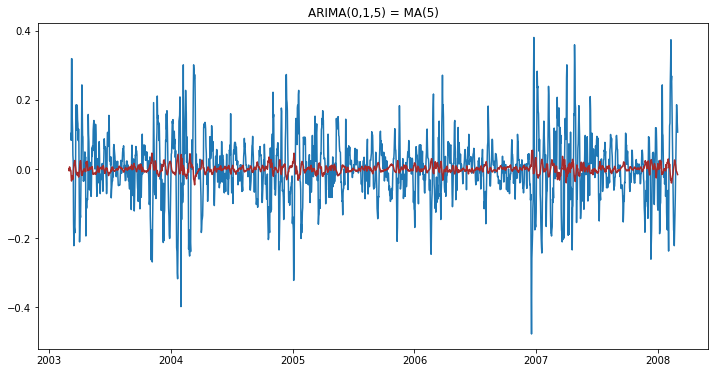

In [159]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(0,1,5), missing='drop')
results_MA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_MA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1826
Model:                 ARIMA(2, 1, 5)   Log Likelihood                3206.773
Method:                       css-mle   S.D. of innovations              0.042
Date:                Sat, 20 Feb 2021   AIC                          -6395.546
Time:                        01:31:10   BIC                          -6345.957
Sample:                    03-02-2003   HQIC                         -6377.254
                         - 02-29-2008                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.869e-05      0.000      0.096      0.924      -0.001       0.001
ar.L1.D.Tmax    -0.2669      0.050     -5.338      0.000      -0.365      -0.169
ar.L2.D.Tmax     0.6991      0.048     14.49

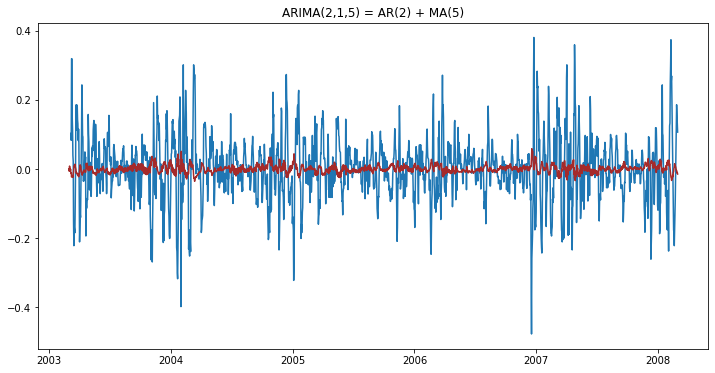

In [160]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMX = ARIMA(ts_test_TMX_log, order=(2,1,5), missing='drop')
results_ARIMA_TMX = model_TMX.fit(displ=-1)
plt.plot(ts_test_log_diff_TMX)
plt.plot(results_ARIMA_TMX.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMX.summary());

In [161]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMX = pd.Series(results_ARIMA_TMX.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMX)

Fecha
2003-03-02    0.000029
2003-03-03   -0.006379
2003-03-04    0.008336
2003-03-05    0.002974
2003-03-06   -0.006732
                ...   
2008-02-25   -0.003870
2008-02-26   -0.004227
2008-02-27   -0.011559
2008-02-28   -0.010032
2008-02-29   -0.014662
Length: 1826, dtype: float64


In [162]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMX = pd.Series(ts_test_TMX_log, index = ts_test_TMX_log.index)
predictions_ARIMA_log_TMX = predictions_ARIMA_log_TMX.add(predictions_ARIMA_diff_TMX)
print(predictions_ARIMA_log_TMX.head())
print(predictions_ARIMA_log_TMX.tail())

Fecha
2003-03-01         NaN
2003-03-02    1.278782
2003-03-03    1.072803
2003-03-04    1.087518
2003-03-05    1.233423
dtype: float64
Fecha
2008-02-25    1.318349
2008-02-26    1.357501
2008-02-27    1.350169
2008-02-28    1.370180
2008-02-29    1.347066
dtype: float64


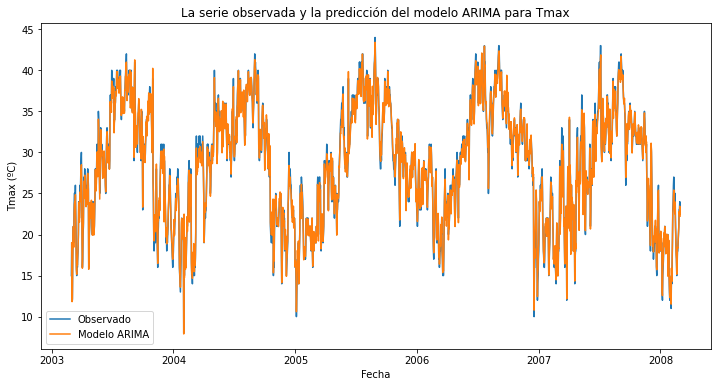

In [163]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMX = 10**(predictions_ARIMA_log_TMX)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMX, label='Observado');
plt.plot(predictions_ARIMA_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [164]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMX = np.sqrt(np.mean((predictions_ARIMA_TMX - ts_test_TMX)**2))
print('RMSE:', RMSE_TMX)

RMSE: 0.6307791490198167


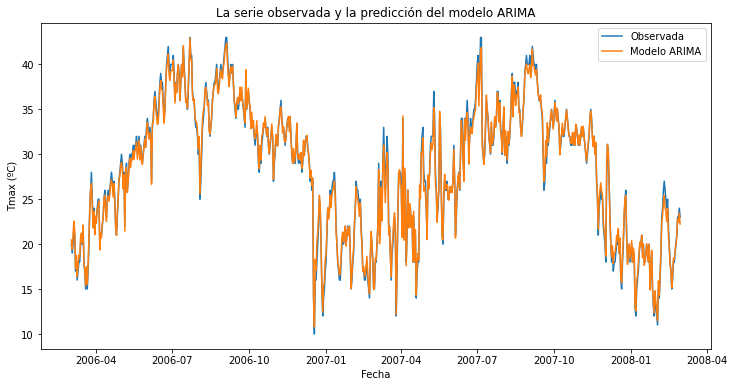

In [165]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMX = ts_test_TMX.tail(730)
predictions_ARIMA_last_TMX = predictions_ARIMA_TMX.tail(730)
plt.plot(ts_test_last_TMX, label='Observada');
plt.plot(predictions_ARIMA_last_TMX, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

## **Temperatura Mínima**

In [166]:
# Convertimos Tmin de ºC a ºK para poder usar escala logaritmica

C = 273.15
ts_90['TK'] = df_90['Tmin'] + C
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes,TK
Fecha,,,,,,,
2003-03-01,0.0,NaN,15.0,4.0,2003,Mar,277.15
2003-03-02,0.0,NaN,19.0,3.0,2003,Mar,276.15
2003-03-03,20.0,NaN,12.0,2.0,2003,Mar,275.15
2003-03-04,5.4,NaN,12.0,2.0,2003,Mar,275.15
2003-03-05,0.0,NaN,17.0,3.0,2003,Mar,276.15


In [167]:
# Vemos su encabezado
ts_90['TK'].head()

Fecha
2003-03-01    277.15
2003-03-02    276.15
2003-03-03    275.15
2003-03-04    275.15
2003-03-05    276.15
Name: TK, dtype: float64

In [168]:
# Definimos la Serie de Tiempo con Tmin que vamos a estudiar, le damos un nombre genérico
ts_test_TMN = ts_90['TK'].copy()

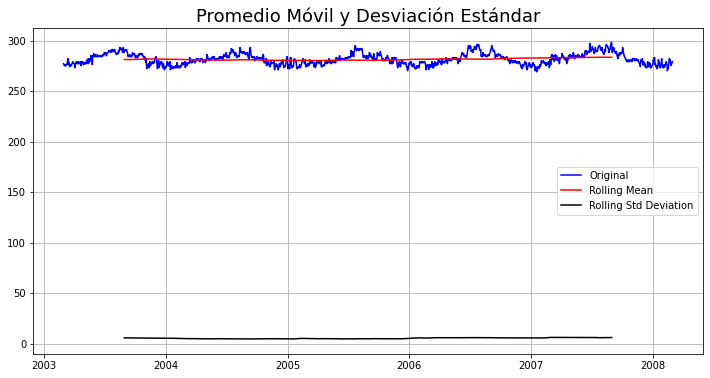

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.732738
p-value                           0.068543
#Lags Used                       19.000000
Number of Observations Used    1807.000000
Critical Value (1%)              -3.433974
Critical Value (5%)              -2.863141
Critical Value (10%)             -2.567622
dtype: float64


In [169]:
# Realizamos la Prueba de Estacionaridad de Tmin
test_stationarity(ts_test_TMN)

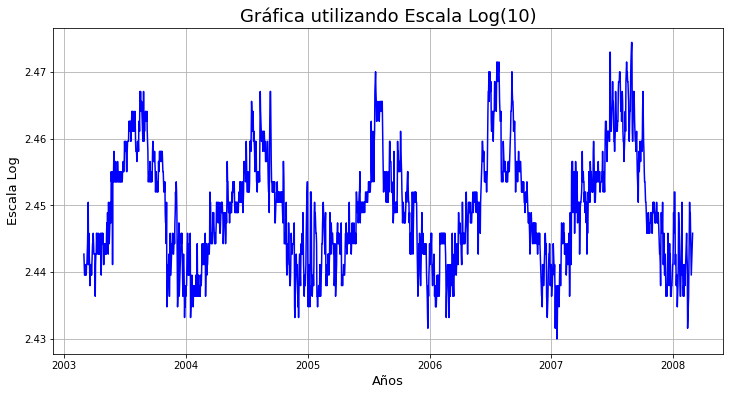

In [170]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_test_TMN_log = np.log10(ts_test_TMN)
plt.plot(ts_test_TMN_log, color='blue')
plt.xlabel('Años',size=13)
plt.ylabel('Escala Log',size=13)
plt.title('Gráfica utilizando Escala Log(10)',size=18)
plt.grid()
plt.show();

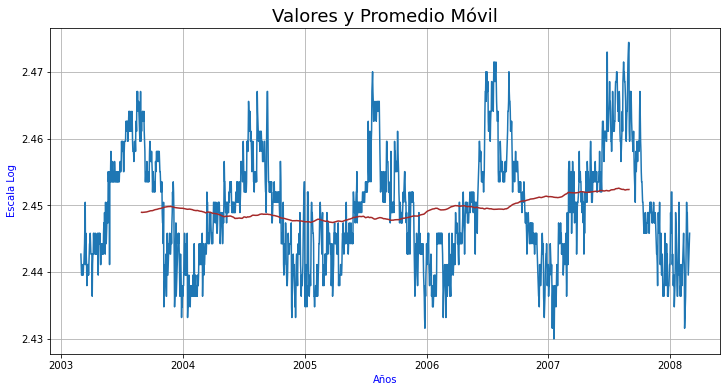

In [171]:
moving_avg_TMN = ts_test_TMN_log.rolling(365, center=True).mean()
plt.plot(ts_test_TMN_log)
plt.plot(moving_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil', size=18)
plt.grid()
plt.show();

In [172]:
ts_test_log_moving_ave_diff_TMN = ts_test_TMN_log - moving_avg_TMN 
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-03-01   NaN
2003-03-02   NaN
2003-03-03   NaN
2003-03-04   NaN
2003-03-05   NaN
Name: TK, dtype: float64

In [173]:
ts_test_log_moving_ave_diff_TMN.dropna(inplace=True)
ts_test_log_moving_ave_diff_TMN.head()

Fecha
2003-08-30    0.012146
2003-08-31    0.013663
2003-09-01    0.013667
2003-09-02    0.015148
2003-09-03    0.013641
Name: TK, dtype: float64

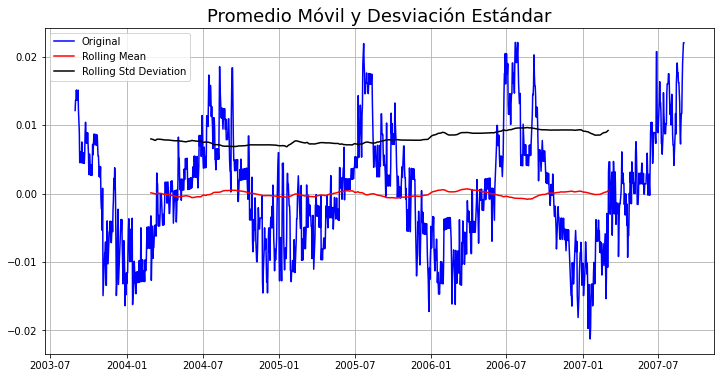

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -1.976792
p-value                           0.296841
#Lags Used                       19.000000
Number of Observations Used    1443.000000
Critical Value (1%)              -3.434890
Critical Value (5%)              -2.863545
Critical Value (10%)             -2.567837
dtype: float64


In [174]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_test_log_moving_ave_diff_TMN)

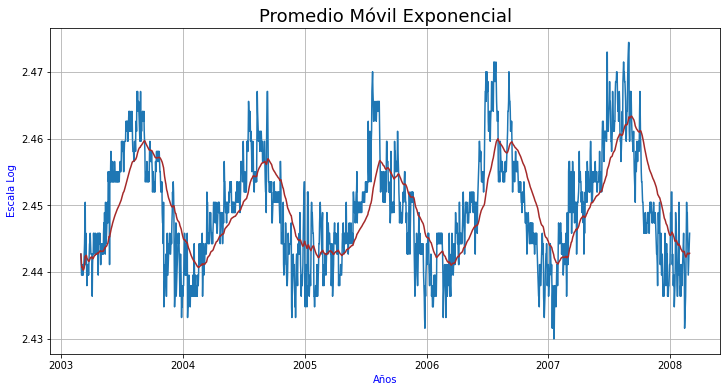

In [175]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg_TMN = ts_test_TMN_log.ewm(halflife=30).mean()
plt.plot(ts_test_TMN_log)
plt.plot(EWM_avg_TMN, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Promedio Móvil Exponencial', size=18)
plt.grid()
plt.show();

In [176]:
EWM_avg_TMX.head()

Fecha
2003-03-01    1.176091
2003-03-02    1.228015
2003-03-03    1.177253
2003-03-04    1.151879
2003-03-05    1.168328
Name: Tmax, dtype: float64

In [177]:
# Probamos la estacionarida de la diferencia 
ts_test_log_EWM_avg_diff_TMN = ts_test_TMN_log - EWM_avg_TMN

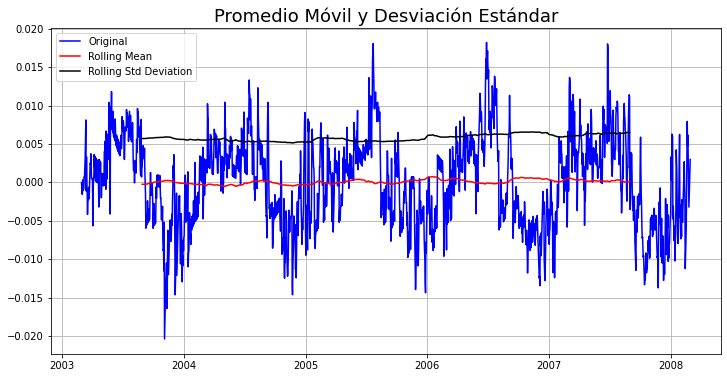

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.727161
p-value                           0.003747
#Lags Used                       19.000000
Number of Observations Used    1807.000000
Critical Value (1%)              -3.433974
Critical Value (5%)              -2.863141
Critical Value (10%)             -2.567622
dtype: float64


In [178]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_test_log_EWM_avg_diff_TMN)

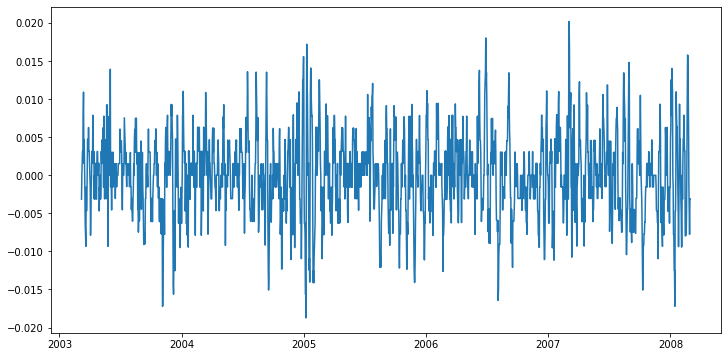

In [179]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff_TMN = ts_test_TMN_log - ts_test_TMN_log.shift(periods=7)
plt.plot(ts_test_log_diff_TMN);

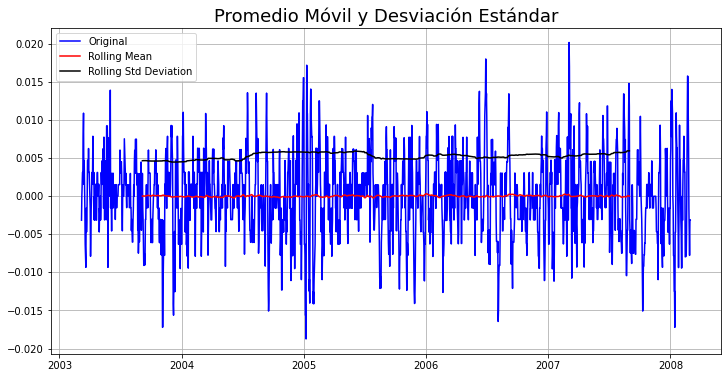

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.987123e+00
p-value                        7.051692e-15
#Lags Used                     2.100000e+01
Number of Observations Used    1.798000e+03
Critical Value (1%)           -3.433992e+00
Critical Value (5%)           -2.863149e+00
Critical Value (10%)          -2.567626e+00
dtype: float64


In [180]:
# Probamos la estacionaridad
ts_test_log_diff_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_diff_TMN)

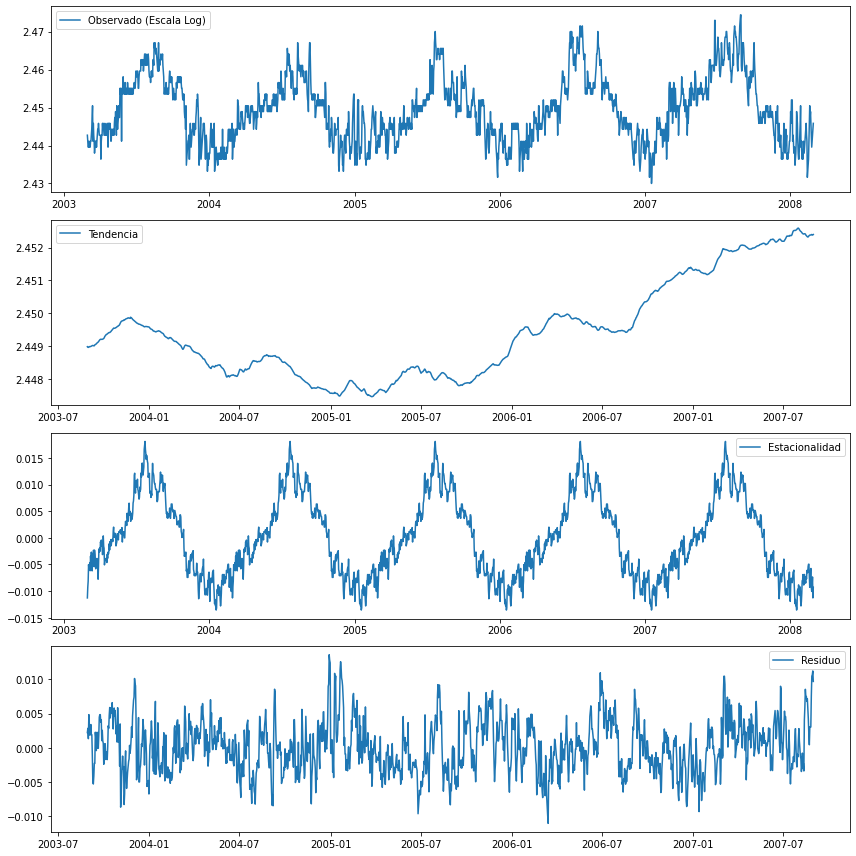

In [181]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition_TMN = sm.tsa.seasonal_decompose(ts_test_TMN_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend_TMN = decomposition_TMN.trend
seasonal_TMN = decomposition_TMN.seasonal
residue_TMN = decomposition_TMN.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_TMN_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend_TMN, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal_TMN, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue_TMN, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

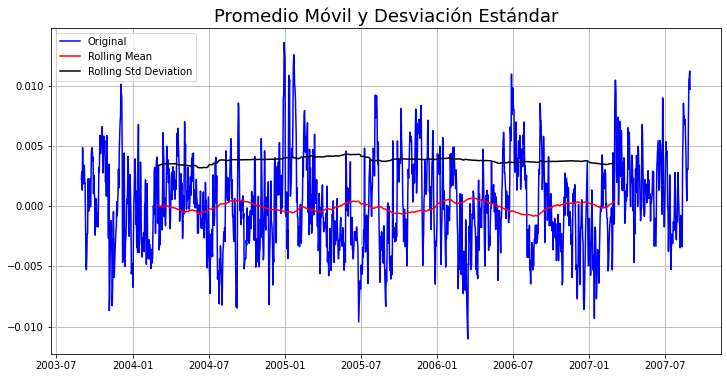

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.286458e+00
p-value                        1.211767e-15
#Lags Used                     4.000000e+00
Number of Observations Used    1.458000e+03
Critical Value (1%)           -3.434843e+00
Critical Value (5%)           -2.863524e+00
Critical Value (10%)          -2.567826e+00
dtype: float64


In [182]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_test_log_decompose_TMN = residue_TMN 
ts_test_log_decompose_TMN.dropna(inplace=True)
test_stationarity(ts_test_log_decompose_TMN)

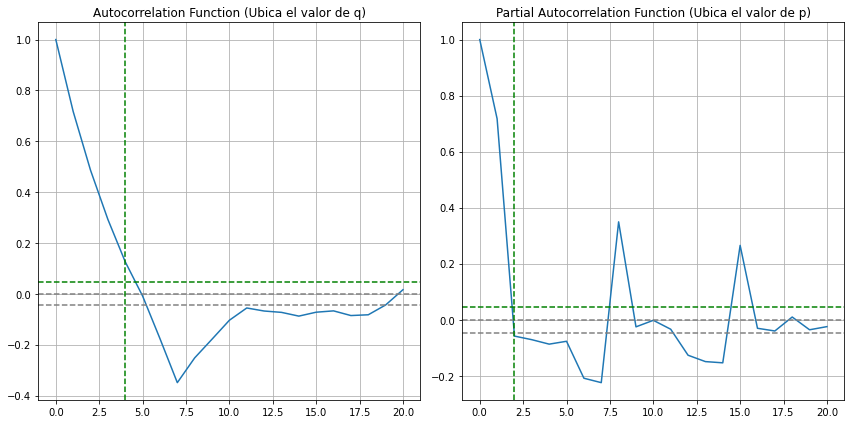

In [183]:
# Aplicamos ARIMA

lag_acf_TMN = acf(ts_test_log_diff_TMN, nlags=20)
lag_pacf_TMN = pacf(ts_test_log_diff_TMN, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf_TMN)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff_TMN)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(2, 1, 0)   Log Likelihood                8156.424
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16304.848
Time:                        01:31:17   BIC                         -16282.809
Sample:                    03-02-2003   HQIC                        -16296.718
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.707e-06   5.34e-05      0.032      0.974      -0.000       0.000
ar.L1.D.TK    -0.1317      0.023     -5.648      0.000      -0.177      -0.086
ar.L2.D.TK    -0.0864      0.023     -3.707      0.0

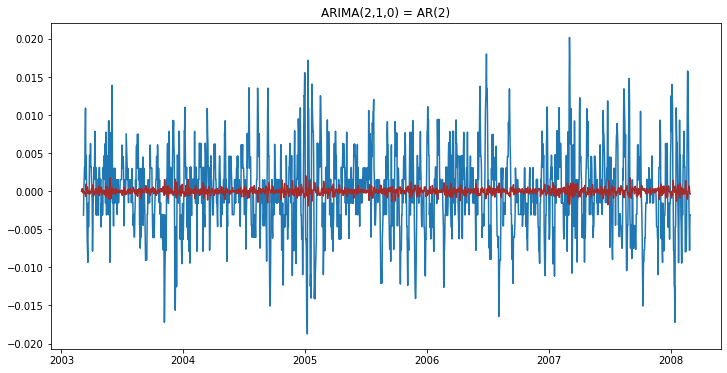

In [184]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,0), missing='drop')
results_AR_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_AR_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR_TMN.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(0, 1, 5)   Log Likelihood                8198.944
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16383.888
Time:                        01:31:17   BIC                         -16345.319
Sample:                    03-02-2003   HQIC                        -16369.661
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.342e-06   2.61e-05      0.051      0.959   -4.98e-05    5.25e-05
ma.L1.D.TK    -0.1829      0.023     -7.802      0.000      -0.229      -0.137
ma.L2.D.TK    -0.1256      0.024     -5.300      0.0

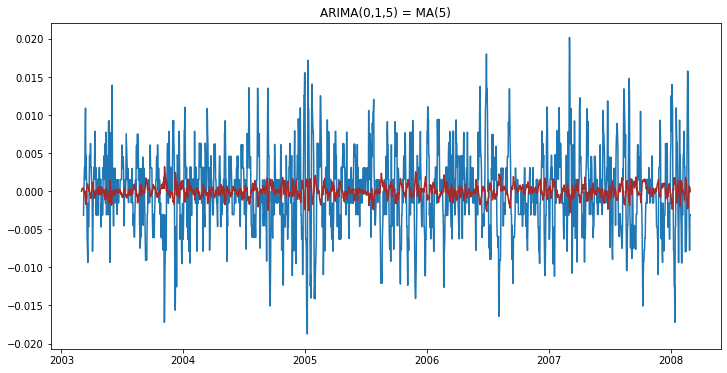

In [185]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(0,1,5), missing='drop')
results_MA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_MA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA_TMN.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                   D.TK   No. Observations:                 1826
Model:                 ARIMA(2, 1, 5)   Log Likelihood                8204.499
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sat, 20 Feb 2021   AIC                         -16390.998
Time:                        01:31:20   BIC                         -16341.409
Sample:                    03-02-2003   HQIC                        -16372.706
                         - 02-29-2008                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.109e-06   2.32e-05      0.048      0.962   -4.44e-05    4.66e-05
ar.L1.D.TK    -0.2571      0.183     -1.404      0.161      -0.616       0.102
ar.L2.D.TK     0.5350      0.114      4.698      0.0

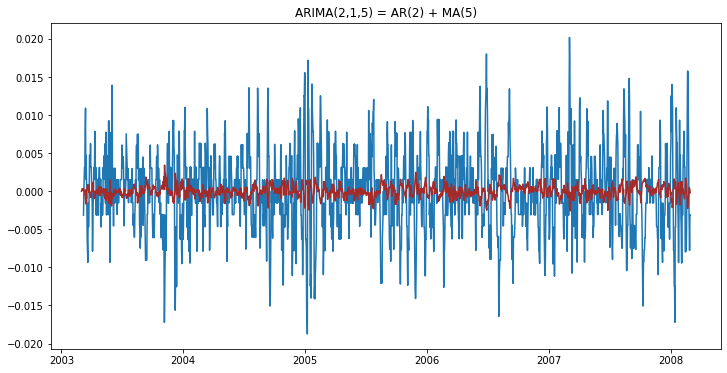

In [186]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model_TMN = ARIMA(ts_test_TMN_log, order=(2,1,5), missing='drop')
results_ARIMA_TMN = model_TMN.fit(displ=-1)
plt.plot(ts_test_log_diff_TMN)
plt.plot(results_ARIMA_TMN.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA_TMN.summary());

In [187]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff_TMN = pd.Series(results_ARIMA_TMN.fittedvalues, copy=True)
print(predictions_ARIMA_diff_TMN)

Fecha
2003-03-02    0.000001
2003-03-03    0.000188
2003-03-04    0.000337
2003-03-05    0.000345
2003-03-06    0.000161
                ...   
2008-02-25   -0.000170
2008-02-26    0.000477
2008-02-27    0.000398
2008-02-28    0.000093
2008-02-29   -0.000193
Length: 1826, dtype: float64


In [188]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log_TMN = pd.Series(ts_test_TMN_log, index = ts_test_TMN_log.index)
predictions_ARIMA_log_TMN = predictions_ARIMA_log_TMN.add(predictions_ARIMA_diff_TMN)
print(predictions_ARIMA_log_TMN.head())
print(predictions_ARIMA_log_TMN.tail())

Fecha
2003-03-01         NaN
2003-03-02    2.441146
2003-03-03    2.439758
2003-03-04    2.439907
2003-03-05    2.441490
dtype: float64
Fecha
2008-02-25    2.439400
2008-02-26    2.441622
2008-02-27    2.443113
2008-02-28    2.444372
2008-02-29    2.445645
dtype: float64


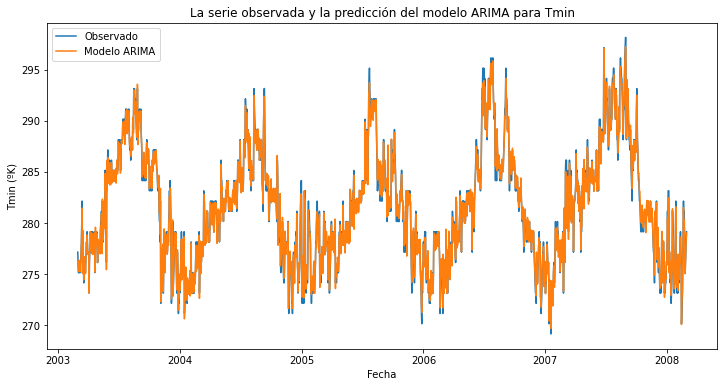

In [189]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA_TMN = 10**(predictions_ARIMA_log_TMN)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test_TMN, label='Observado');
plt.plot(predictions_ARIMA_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºK)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

In [190]:
print(predictions_ARIMA_TMN)

Fecha
2003-03-01           NaN
2003-03-02    276.150705
2003-03-03    275.269152
2003-03-04    275.363672
2003-03-05    276.369181
                 ...    
2008-02-25    275.042504
2008-02-26    276.453578
2008-02-27    277.404243
2008-02-28    278.209654
2008-02-29    279.026070
Length: 1827, dtype: float64


In [191]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE_TMN = np.sqrt(np.mean((predictions_ARIMA_TMN - ts_test_TMN)**2))
print('RMSE:', RMSE_TMN)

RMSE: 0.49308690752165574


In [192]:
# Convertimos temperaturas de ºK a ºC

C = 273.15

predictions_ARIMA_TMN_C = predictions_ARIMA_TMN - C
print(predictions_ARIMA_TMN_C.head())

ts_test_TMN_C = ts_test_TMN - C
print(ts_test_TMN_C.head())

Fecha
2003-03-01         NaN
2003-03-02    3.000705
2003-03-03    2.119152
2003-03-04    2.213672
2003-03-05    3.219181
dtype: float64
Fecha
2003-03-01    4.0
2003-03-02    3.0
2003-03-03    2.0
2003-03-04    2.0
2003-03-05    3.0
Name: TK, dtype: float64


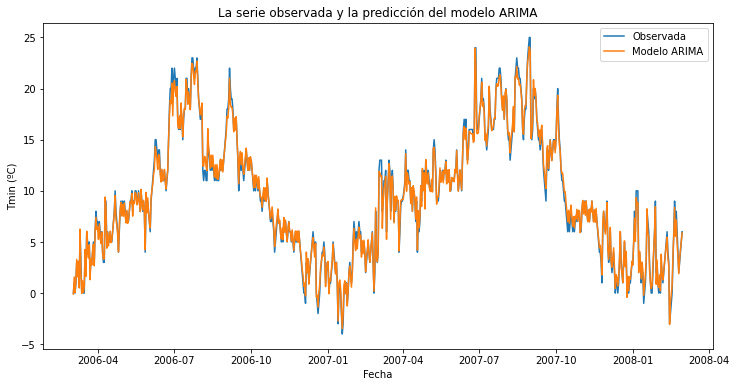

In [193]:
# Graficamos sólo los útimos datos de las series 
ts_test_last_TMN_C = ts_test_TMN_C.tail(730)
predictions_ARIMA_last_TMN = predictions_ARIMA_TMN_C.tail(730)
plt.plot(ts_test_last_TMN_C, label='Observada');
plt.plot(predictions_ARIMA_last_TMN, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');